**Математические основы машинного обучения II**
*Домашнее задание №1. Регрессия*
**Выполнила Савоськиной С.В.**

# 1. Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor, NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import preprocessing as prep
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 2. Настройка параметров

In [2]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision",6)
pd.set_option("plotting.backend", "matplotlib")
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')

#Для корректного отображения графиков в ноутбуках используется команда %matplotlib inline
%matplotlib inline
# для корректного отображения графиков на тёмном фоне
plt.style.use('default')

# sns.axes_style()
# custom = {"axes.edgecolor": "white", "grid.linestyle": "dashed", "grid.color": "black"}
# sns.set_style("whitegrid", rc = custom)
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(20, 5)})

# 3. Код (вспомогательные методы)

In [3]:
RANDOM_STATE = 18
TEST_SIZE = 0.3
LOCAL_FOLDER = './data/'

# Столбцы, содержащие категориальные признаки
CAT_FEATURES=['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
              'Utilities', 'LotConfig',  'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
              'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
              'Exterior1st',  'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
              'BsmtQual', 'BsmtCond', 'BsmtExposure',  'BsmtFinType1',  'BsmtFinType2',
              'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
              'FireplaceQu', 'GarageType', 'GarageFinish',  'GarageQual', 'GarageCond',
              'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

# Столбцы, содержащие числовые признаки
NUM_FEATURES=['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
               'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
               'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
                'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
               'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
               'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

# Столбцы, содержащие порядковые и интервальные числовые признаки. Они содержат количество, но в ряде случае с ними
# удобнее работать  как с категориальными
ORD_FEATURES =['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
  'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

# Целевой признак для регрессии
TARGET_FEATURE = 'SalePrice'


def show_dataset_info(dataset):
    """
    Вывод основной информации о датасете
    :param dataset: Датасет для обработки
    :return: None
    """
    print(
    f"Размер набора данных: {dataset.shape}",
    f"Дупликатов: {dataset.duplicated().sum()}",
    f"Всего пропусков: {dataset.isna().sum().sum()}",
    f"Пропусков в столбцах: {dataset.loc[:,dataset.isna().sum()>0].isna().sum().sort_values()}",
    sep="\n"
)


def show_column_types(dataset):
    """
    Вывод числовых и категориальных столбцов в датасете
    :param dataset: Датасет для обработки
    :return: кортеж: список категориальных столбцов, список числовых столбцов
    """
    nums_df = dataset[NUM_FEATURES]
    cats_df = dataset[CAT_FEATURES]

    # выводим результат
    print('Категориальные признаки:\t ',cats_df.columns, '\n Число столбцов = ',len(cats_df.columns))
    print('Числовые признаки:\t ',  nums_df.columns, '\n Число столбцов = ',len(nums_df.columns))

    return cats_df.columns, nums_df.columns


def drop_feature(dataset, columns_to_drop, cat_columns, num_columns):
    """
    Удаление признаков (столбцов) из датасета
    :param dataset: Датасет для обработки
    :param columns_to_drop:  Столбцы для удаления
    :param cat_columns: Список категориальных столбцов
    :param num_columns: Список числовых столбцов
    :return: кортеж: новый список категориальных столбцов, новый список числовых столбцов
    """
    for col in columns_to_drop:
        print(f"Удаляется признак {col}")
        dataset.drop(col, axis=1, inplace=True, errors ="ignore")
        if cat_columns is not None:
            cat_columns = cat_columns.drop(col, errors ="ignore")
        if num_columns is not None:
            num_columns = num_columns.drop(col, errors ="ignore")

    return cat_columns, num_columns


def drop_corr_features(dataset, num_columns):
    """
    Удаление коррелирующих признаков
    :param dataset: Датасет для обработки
    :param num_columns: Числовые столбцы для обработки
    :return: кортеж: обработанный датасет, новый список числовых столбцов
    """
    correlations = dataset[num_columns.append(pd.Index([TARGET_FEATURE]))].corr()
    dropped=[]

    for row_idx, row in enumerate(correlations.index.drop([TARGET_FEATURE])):
        for col_idx in range(row_idx+1, len(correlations.index)):
            if (row_idx !=col_idx and row_idx not in dropped and col_idx not in dropped
                    and abs(correlations.iloc[row_idx, col_idx])>0.7):
                print(f"Признак {row} с признаком {correlations.columns[col_idx]} имеет коэффициент корреляции",
                   correlations.iloc[row_idx, col_idx])
                col_to_drop=[]
                if abs(correlations.loc[row, TARGET_FEATURE]) >= abs(correlations.iloc[col_idx, len(correlations.index)-1]):
                    col_to_drop.append(correlations.columns[col_idx])
                    dropped.append(col_idx)
                else:
                    col_to_drop.append(row)
                    dropped.append(row_idx)

                _, num_columns = drop_feature(dataset, col_to_drop, None, num_columns)

    return dataset, num_columns


def show_hist(dataset, columns, log_columns):
    """
    Показ гистограмм для нескольких столбцов
    :param dataset: Датасет для обработки
    :param columns: Столбцы для обработки
    :param log_columns: столбцы, для которых необходимо выполнить логарифмирование
    :return: None
    """
    _cols = 4
    _rows = int(np.ceil(len(columns) / _cols))

    fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(12, 12))
    ax = ax.flatten()

    for idx, column_name in enumerate(columns):
        hplot = sns.histplot(dataset, x= dataset[column_name], ax=ax[idx] ,
                             log_scale = column_name in log_columns, bins=16, color='lime')
        hplot.grid()

def search_outliers(feature):
    """
    Поиск выбросов в столбце
    :param feature: Столбец для обработки
    :return: количество выбросов в столбце
    """
    q1, q3 = np.percentile(feature, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return np.where((feature < lower_bound) | (feature > upper_bound))[0]


def show_outliers(dataset, columns):
    """
    Вывод количества выбросов по столбцам
    :param dataset: Датасет для обработки
    :param columns: Столбцы для обработки
    :return: None
    """
    for col in columns:
        outliers=search_outliers(dataset[col])
        sum_outliers = len(outliers)
        print(f"Признак {col} содержит {sum_outliers} выбросов из {dataset[col].shape[0]} наблюдений ({sum_outliers/dataset[col].shape[0]*100:.2f}%)")


def drop_outliers(dataset, columns):
    """
    Удаление выбросов
    :param dataset: Датасет для обработки
    :param columns: Столбцы для обработки
    :return: Датасет с удаленными выбросами
    """

    for col in columns:
        q1, q3 = np.percentile(dataset[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        sub_dataset=dataset[(dataset[col] < lower_bound) | (dataset[col] > upper_bound)]
        dataset = dataset.drop(sub_dataset.index)

    dataset = dataset.reset_index(drop=True)
    return dataset


def regression_metrics(pipeline, X_test, y_test):
    """
    Вывод метрик
    :param pipeline: обученный пайплайн обработки
    :param X_test: тестовая выборка
    :param y_test: значения целевой переменной для тестовой выборки
    :return: None
    """
    y_pred = pipeline.predict(X_test)
    print("r2_score: ", r2_score(y_test, y_pred))
    print("rmse: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("mae: ", mean_absolute_error(y_test, y_pred))

def print_stem(y, label, marker):
    markerline, stemlines, baseline = plt.stem(y, markerfmt=marker,label = label)
    markerline.set_markerfacecolor('none')

# 4. Загрузка и подготовка данных
## 4.1. Загрузка данных

Загружаем датасет из https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [4]:
datafile = LOCAL_FOLDER + 'train.csv'
df = pd.read_csv(datafile, sep=',', index_col='Id',  low_memory=False)

df.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1008,160,RM,21.0,2217,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,88000
1426,20,RL,80.0,10721,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2008,WD,Normal,142000
531,80,RL,85.0,10200,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2008,WD,Abnorml,175000
906,20,RL,80.0,9920,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,128000
1163,20,RL,109.0,8724,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,129000


## 4.2. Информация о DataFrame

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [6]:
show_dataset_info(df)

Размер набора данных: (1460, 80)
Дупликатов: 0
Всего пропусков: 7829
Пропусков в столбцах: Electrical         1
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageYrBlt       81
GarageType        81
LotFrontage      259
FireplaceQu      690
MasVnrType       872
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64


In [7]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
df.describe(include=['object','datetime64[ns]', 'category'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [9]:
cat_columns, num_columns = show_column_types(df)

Категориальные признаки:	  Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object') 
 Число столбцов =  46
Числовые признаки:	  Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'Bsmt

В датасете 1460 строки, 80 столбцов, часть из них текстовые, часть числовые. Большая часть столбцов, как числовых,
так и строковых, содержат категориальные данные (это известно из описания датасета, не приведенного здесь). Категориальных столбцов - 46, числовых - 33.
Целевой столбец - SalePrice - цена продажи дома. Цена продажи дома варьируется от 34900 до 755000, средняя цена 180900, что немного выше медианного значения 163000, что говорит о небольшом преобладании домов с более низкой ценой.
Много пропусков в разных столбцах. Особенно много в столбцах LotFrontage (259), FireplaceQu (690), MasVnrType (872),
Fence (1179), Alley (1369), MiscFeature (1406), PoolQC (1453). Они будут удалены.
Дупликатов нет.

## 4.3. Предобработка данных

Удалим признаки для которых слишком много пропусков

In [10]:
columns_to_drop=df.columns[df.isna().sum()>400]
cat_columns, num_columns = drop_feature(df, columns_to_drop,cat_columns,num_columns)
show_dataset_info(df)

Удаляется признак Alley
Удаляется признак MasVnrType
Удаляется признак FireplaceQu
Удаляется признак PoolQC
Удаляется признак Fence
Удаляется признак MiscFeature
Размер набора данных: (1460, 74)
Дупликатов: 0
Всего пропусков: 860
Пропусков в столбцах: Electrical        1
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
BsmtExposure     38
BsmtFinType2     38
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
LotFrontage     259
dtype: int64


Датасет содержит очень много признаков. Оценим их влияние через их вариативность. Оставим только те
признаки, у которых скопление значений по отдельным категориям не превышает порога в 0.8.

In [11]:
for cat_col in df.columns:
    total_count = df[cat_col].count()
    most_count = df[cat_col].value_counts().sort_values(ascending=False).iloc[0]
    var_coef = most_count / total_count
    if var_coef > 0.8:
        print(f'Найдено превалирующее значение {most_count} в столбце {cat_col}')
        cat_columns, num_columns = drop_feature(df, [cat_col], cat_columns,num_columns)

Найдено превалирующее значение 1454 в столбце Street
Удаляется признак Street
Найдено превалирующее значение 1311 в столбце LandContour
Удаляется признак LandContour
Найдено превалирующее значение 1459 в столбце Utilities
Удаляется признак Utilities
Найдено превалирующее значение 1382 в столбце LandSlope
Удаляется признак LandSlope
Найдено превалирующее значение 1260 в столбце Condition1
Удаляется признак Condition1
Найдено превалирующее значение 1445 в столбце Condition2
Удаляется признак Condition2
Найдено превалирующее значение 1220 в столбце BldgType
Удаляется признак BldgType
Найдено превалирующее значение 1434 в столбце RoofMatl
Удаляется признак RoofMatl
Найдено превалирующее значение 1282 в столбце ExterCond
Удаляется признак ExterCond
Найдено превалирующее значение 1311 в столбце BsmtCond
Удаляется признак BsmtCond
Найдено превалирующее значение 1256 в столбце BsmtFinType2
Удаляется признак BsmtFinType2
Найдено превалирующее значение 1293 в столбце BsmtFinSF2
Удаляется признак

Удалим числовые признаки, которые коррелируют друг с другом

In [12]:
df,num_columns= drop_corr_features(df,num_columns)

Признак YearBuilt с признаком GarageYrBlt имеет коэффициент корреляции 0.8256674841743408
Удаляется признак GarageYrBlt
Признак TotalBsmtSF с признаком 1stFlrSF имеет коэффициент корреляции 0.8195299750050339
Удаляется признак 1stFlrSF
Признак GrLivArea с признаком TotRmsAbvGrd имеет коэффициент корреляции 0.8254893743088425
Удаляется признак TotRmsAbvGrd
Признак GrLivArea с признаком SalePrice имеет коэффициент корреляции 0.7086244776126515
Удаляется признак GrLivArea
Признак GarageCars с признаком GarageArea имеет коэффициент корреляции 0.882475414281462
Удаляется признак GarageArea


Оценим выбросы

Диаграмма размаха


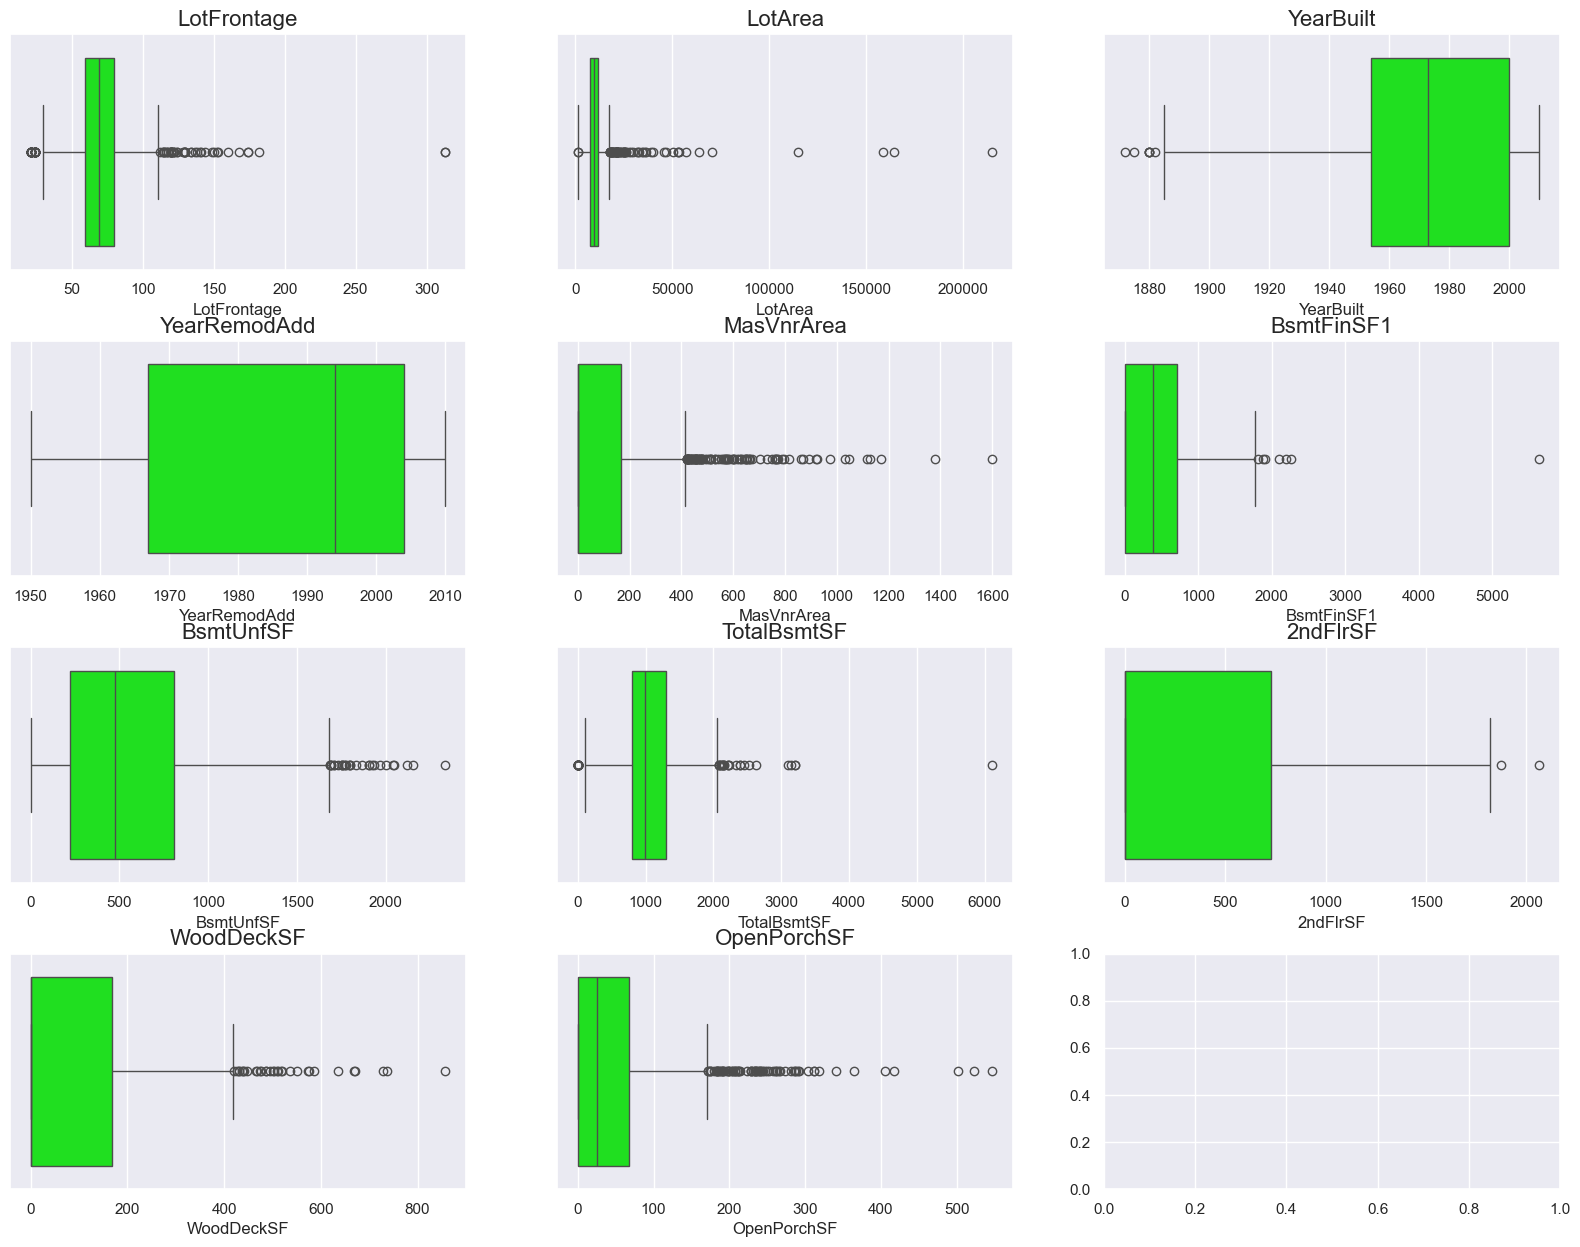

In [13]:
# исключаем столбцы с порядковыми данными
not_ord_columns = num_columns.drop(ORD_FEATURES, errors ="ignore")

num=-1
rows=int(np.ceil(len(not_ord_columns)/3))
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(20, 15))
plt.subplots_adjust(hspace=.3)

print("Диаграмма размаха")
for feature in not_ord_columns:
    num = num+1
    x=num//3
    y=num -3*x
    sns.boxplot(data=df, x=feature, orient='h', color='lime', ax=axes[x,y]).set_title(feature, fontsize=16)

Выбросы есть, у большинства признаков в верхнем диапазоне значений, что видимо связано с отдельными особо крупными
объектами недвижимости. Поскольку таких объектов в выборке мало для получения по ним адекватной статистики,
 их лучше удалить. Посмотрим количество выбросов по каждому признаку

In [14]:
show_outliers(df,not_ord_columns)

Признак LotFrontage содержит 0 выбросов из 1460 наблюдений (0.00%)
Признак LotArea содержит 69 выбросов из 1460 наблюдений (4.73%)
Признак YearBuilt содержит 7 выбросов из 1460 наблюдений (0.48%)
Признак YearRemodAdd содержит 0 выбросов из 1460 наблюдений (0.00%)
Признак MasVnrArea содержит 0 выбросов из 1460 наблюдений (0.00%)
Признак BsmtFinSF1 содержит 7 выбросов из 1460 наблюдений (0.48%)
Признак BsmtUnfSF содержит 29 выбросов из 1460 наблюдений (1.99%)
Признак TotalBsmtSF содержит 61 выбросов из 1460 наблюдений (4.18%)
Признак 2ndFlrSF содержит 2 выбросов из 1460 наблюдений (0.14%)
Признак WoodDeckSF содержит 32 выбросов из 1460 наблюдений (2.19%)
Признак OpenPorchSF содержит 77 выбросов из 1460 наблюдений (5.27%)


Попробуем почистить.

In [15]:
df=drop_outliers(df, not_ord_columns)
show_outliers(df,not_ord_columns)

Признак LotFrontage содержит 0 выбросов из 1201 наблюдений (0.00%)
Признак LotArea содержит 30 выбросов из 1201 наблюдений (2.50%)
Признак YearBuilt содержит 0 выбросов из 1201 наблюдений (0.00%)
Признак YearRemodAdd содержит 0 выбросов из 1201 наблюдений (0.00%)
Признак MasVnrArea содержит 0 выбросов из 1201 наблюдений (0.00%)
Признак BsmtFinSF1 содержит 0 выбросов из 1201 наблюдений (0.00%)
Признак BsmtUnfSF содержит 8 выбросов из 1201 наблюдений (0.67%)
Признак TotalBsmtSF содержит 4 выбросов из 1201 наблюдений (0.33%)
Признак 2ndFlrSF содержит 0 выбросов из 1201 наблюдений (0.00%)
Признак WoodDeckSF содержит 5 выбросов из 1201 наблюдений (0.42%)
Признак OpenPorchSF содержит 30 выбросов из 1201 наблюдений (2.50%)


Количество выбросов значительно уменьшилось. Дальнейшая чистка может привести к значительной потере объема выборки,
поэтому полученные результаты считаем приемлимыми.

Посмотрим на гистограммы числовых признаков, не являющиеся порядковыми.

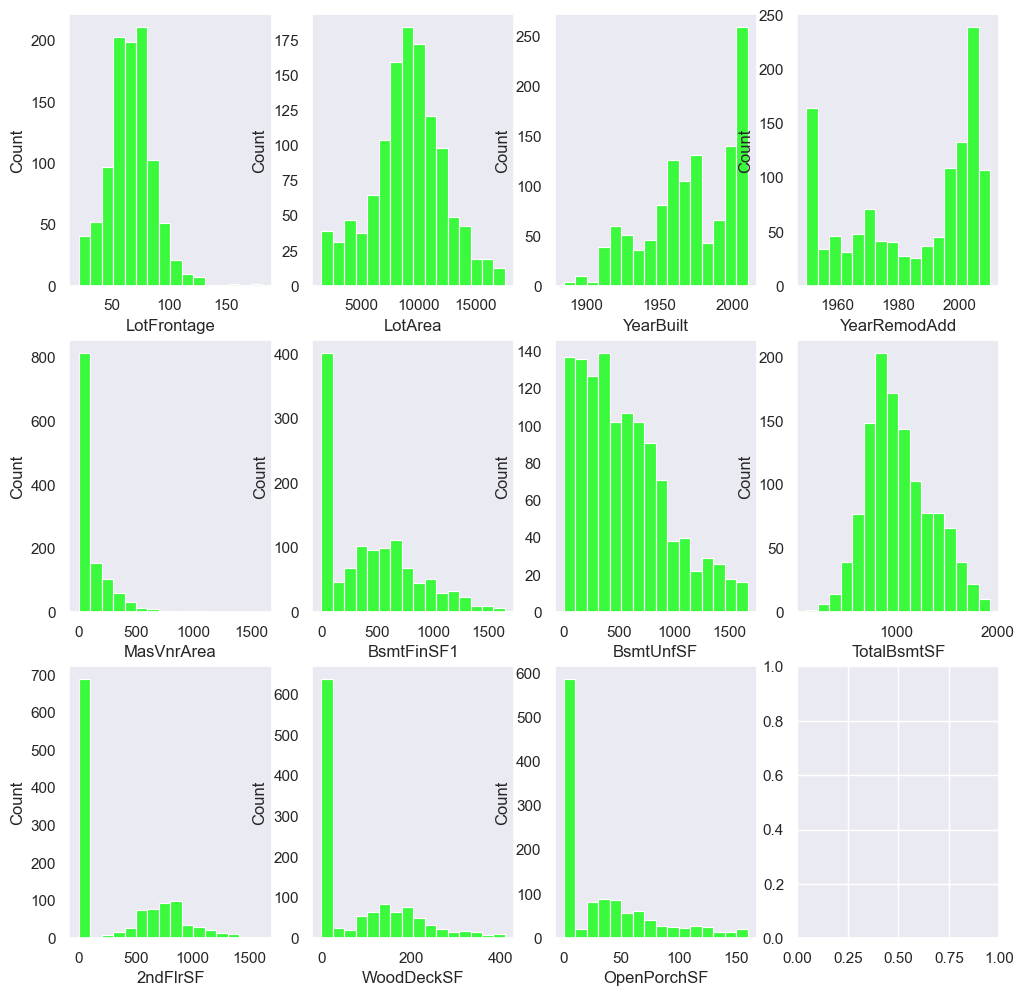

In [16]:
# исключаем столбцы с порядковыми данными
not_ord_columns = num_columns.drop(ORD_FEATURES, errors ="ignore")

show_hist(df, not_ord_columns, [])

Часть признаков не имеет нормального распределения. Кроме того, часть признаков имеет большое преобладание одного
значения (0). Посмотрим на эти признаки в логарифмическом масштабе.

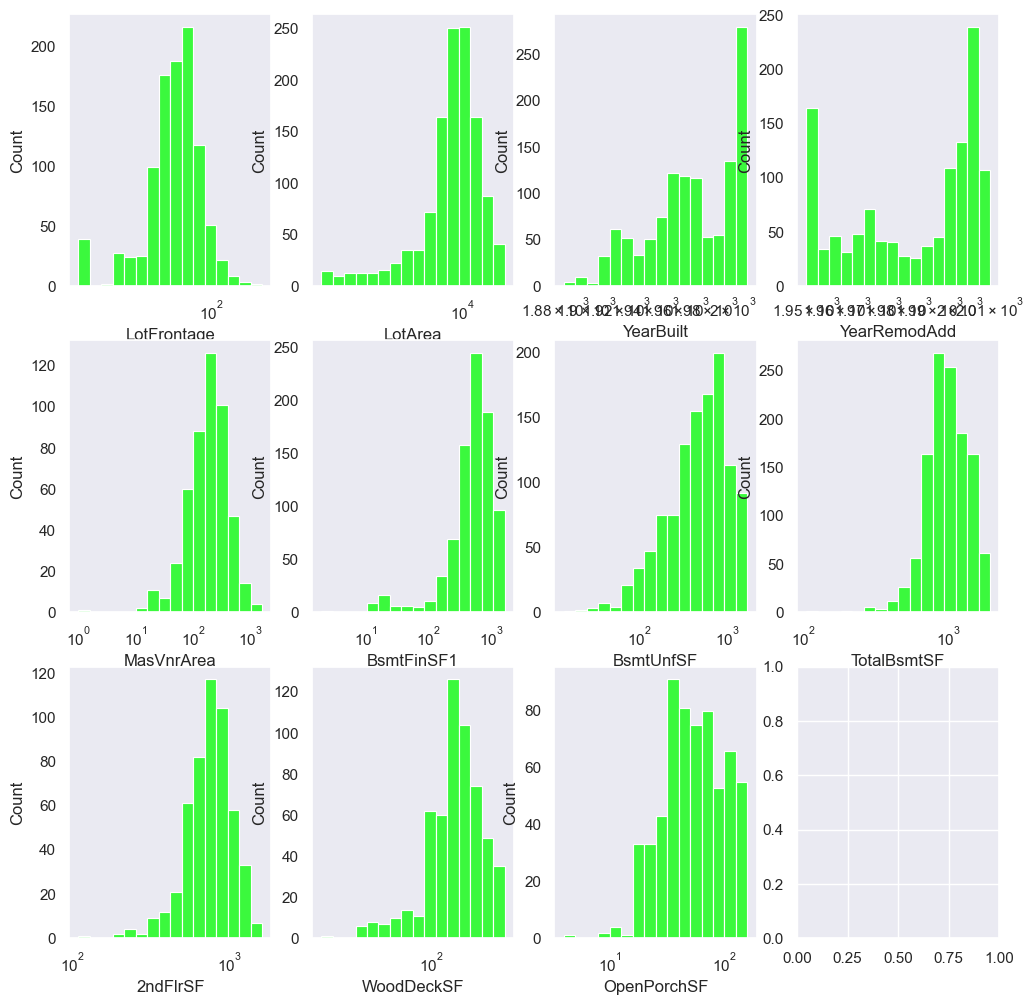

In [17]:
show_hist(df, not_ord_columns, not_ord_columns)

Логарифмирование приблизило распределение к нормальному, но неизвестно, как исчезновение преобладающего значения
повлияет на качество прогноза. Это буду выяснять далее опытным путем.

## 4.4. Исследовательский анализ данных

Оценим распределение целевой переменной.

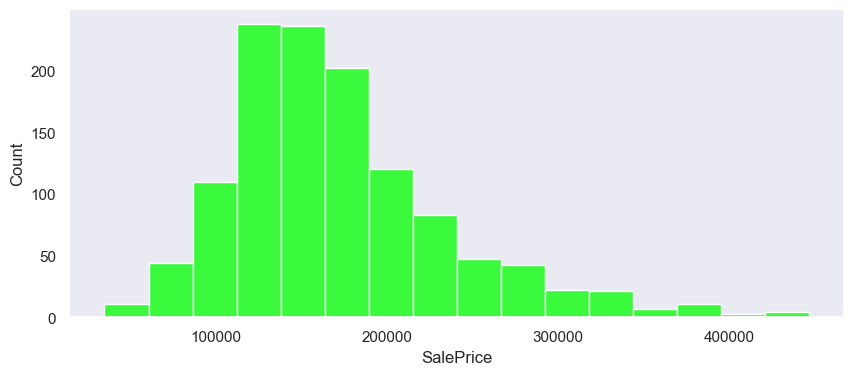

In [19]:
fig = plt.figure(figsize=(10, 4))
sns.histplot(
    df,
    x=TARGET_FEATURE,
    bins=16,
    color='lime').grid()

Почистим выбросы целевой переменной

In [20]:
show_outliers(df,[TARGET_FEATURE])
df=drop_outliers(df, [TARGET_FEATURE])
print('После удаления выбросов:')
show_outliers(df,[TARGET_FEATURE])

Признак SalePrice содержит 59 выбросов из 1201 наблюдений (4.91%)
После удаления выбросов:
Признак SalePrice содержит 15 выбросов из 1142 наблюдений (1.31%)


Пустых значений в целевой переменной:

In [21]:
print(f"Размер набора данных: {len(df[TARGET_FEATURE])}")
print(f"Всего пропусков: {df[TARGET_FEATURE].isna().sum()}")

Размер набора данных: 1142
Всего пропусков: 0


Удалим числовые признаки, которые слабо коррелируют с ценой.

In [22]:
correlations = df[num_columns.append(pd.Index([TARGET_FEATURE]))].corr()

for row in correlations.index:
    if abs(correlations.loc[row, TARGET_FEATURE]) < 0.25:
        print(f"Признак {row} имеет коэффициент корреляции {correlations.loc[row, TARGET_FEATURE]}")
        cat_columns, num_columns = drop_feature(df, [row], cat_columns, num_columns)

Признак BsmtFinSF1 имеет коэффициент корреляции 0.24364970242825942
Удаляется признак BsmtFinSF1
Признак BsmtUnfSF имеет коэффициент корреляции 0.17997828471693245
Удаляется признак BsmtUnfSF
Признак BsmtFullBath имеет коэффициент корреляции 0.14258556277507078
Удаляется признак BsmtFullBath
Признак BedroomAbvGr имеет коэффициент корреляции 0.21343566936871894
Удаляется признак BedroomAbvGr
Признак WoodDeckSF имеет коэффициент корреляции 0.24944741655789823
Удаляется признак WoodDeckSF
Признак MoSold имеет коэффициент корреляции 0.06280699228568674
Удаляется признак MoSold
Признак YrSold имеет коэффициент корреляции -0.04761939209955758
Удаляется признак YrSold


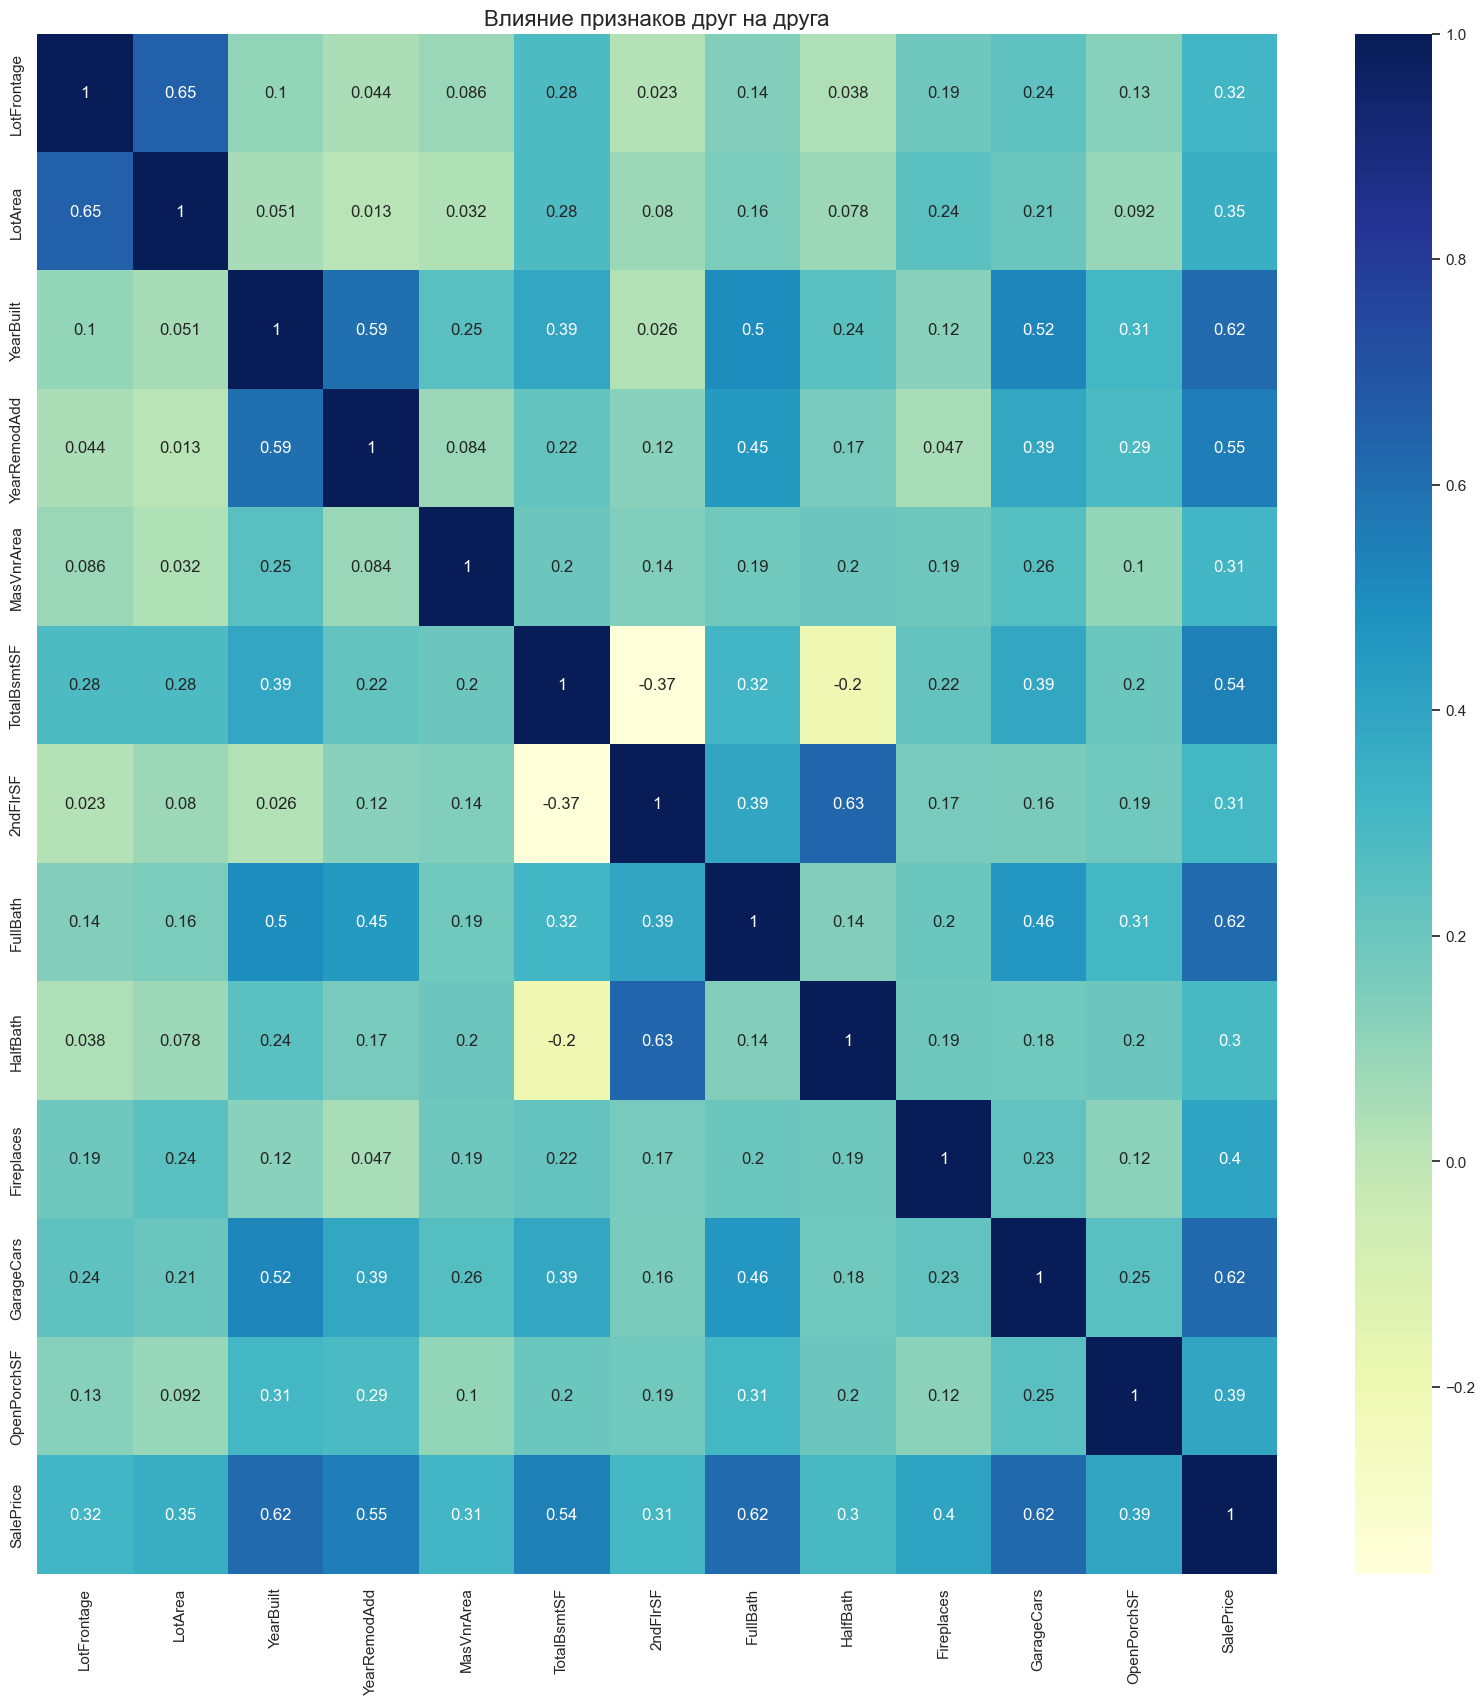

In [23]:
fig = plt.figure(figsize=(20, 20))
plot_data = sns.heatmap(df[num_columns.append(pd.Index([TARGET_FEATURE]))].corr(), cmap="YlGnBu", annot=True);
plot_data.set_title('Влияние признаков друг на друга', fontsize=16);

Оценим волатильность категориальных признаков относительно целевого признака

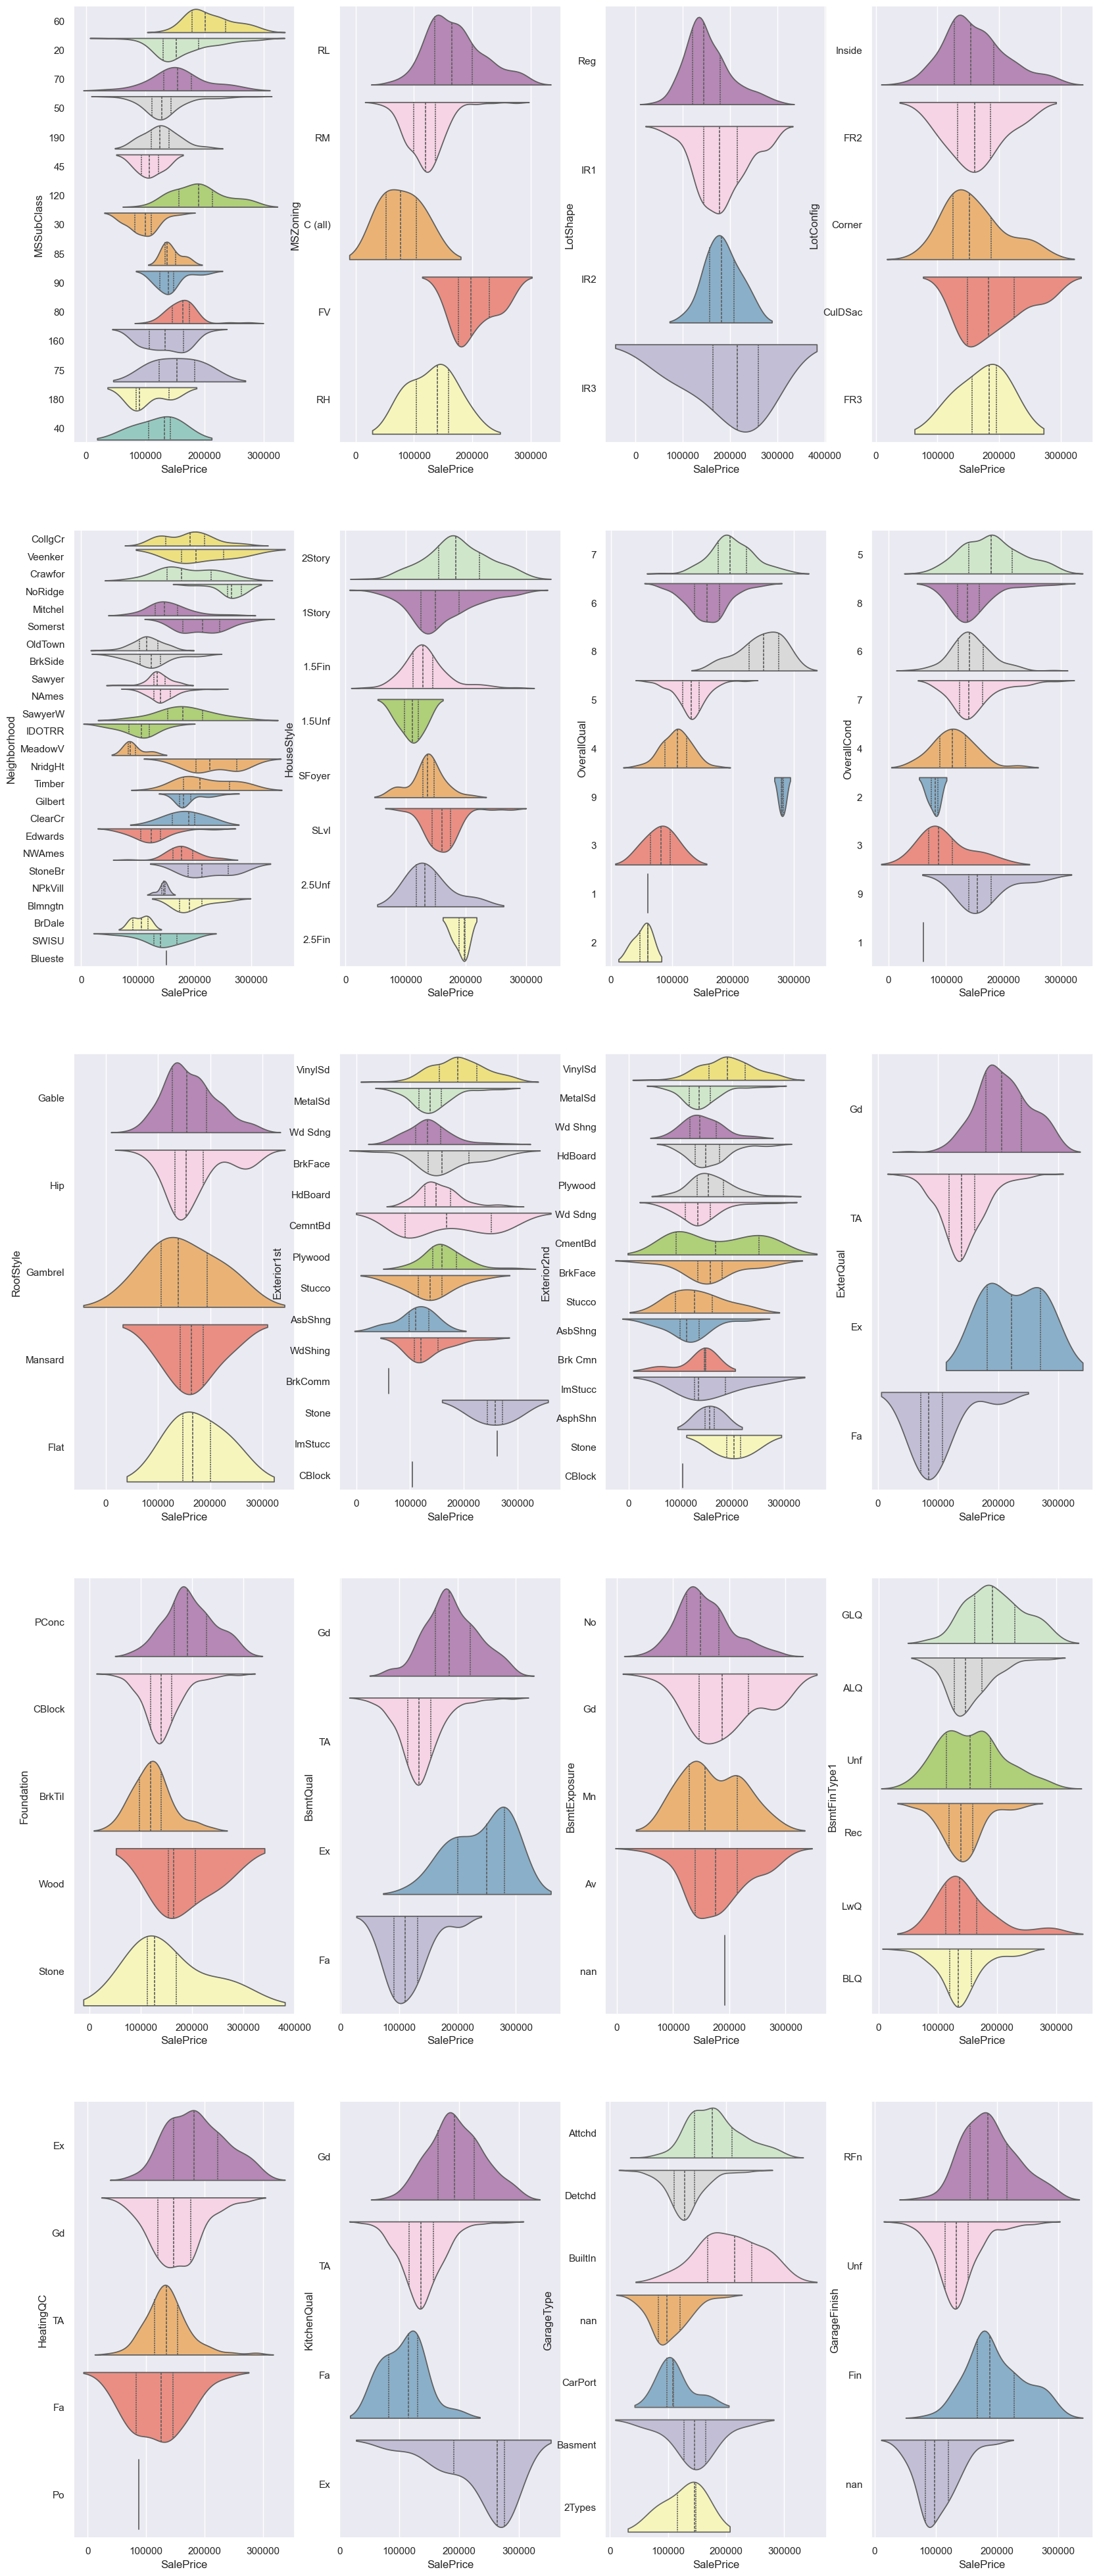

In [24]:
_cols = 4
_rows = int(np.ceil(len(cat_columns) / _cols))
fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(20, 50))
ax = ax.flatten()

for idx, cat_col in enumerate(cat_columns):
    sns.violinplot(
        df,
        x=df[TARGET_FEATURE],
        y=df[cat_col].astype(str),
        ax=ax[idx],
        orient='h',
        split=True,
        inner = "quartile",
        palette="Set3_r"
    )

Оценим распределение значений категориальных признаков

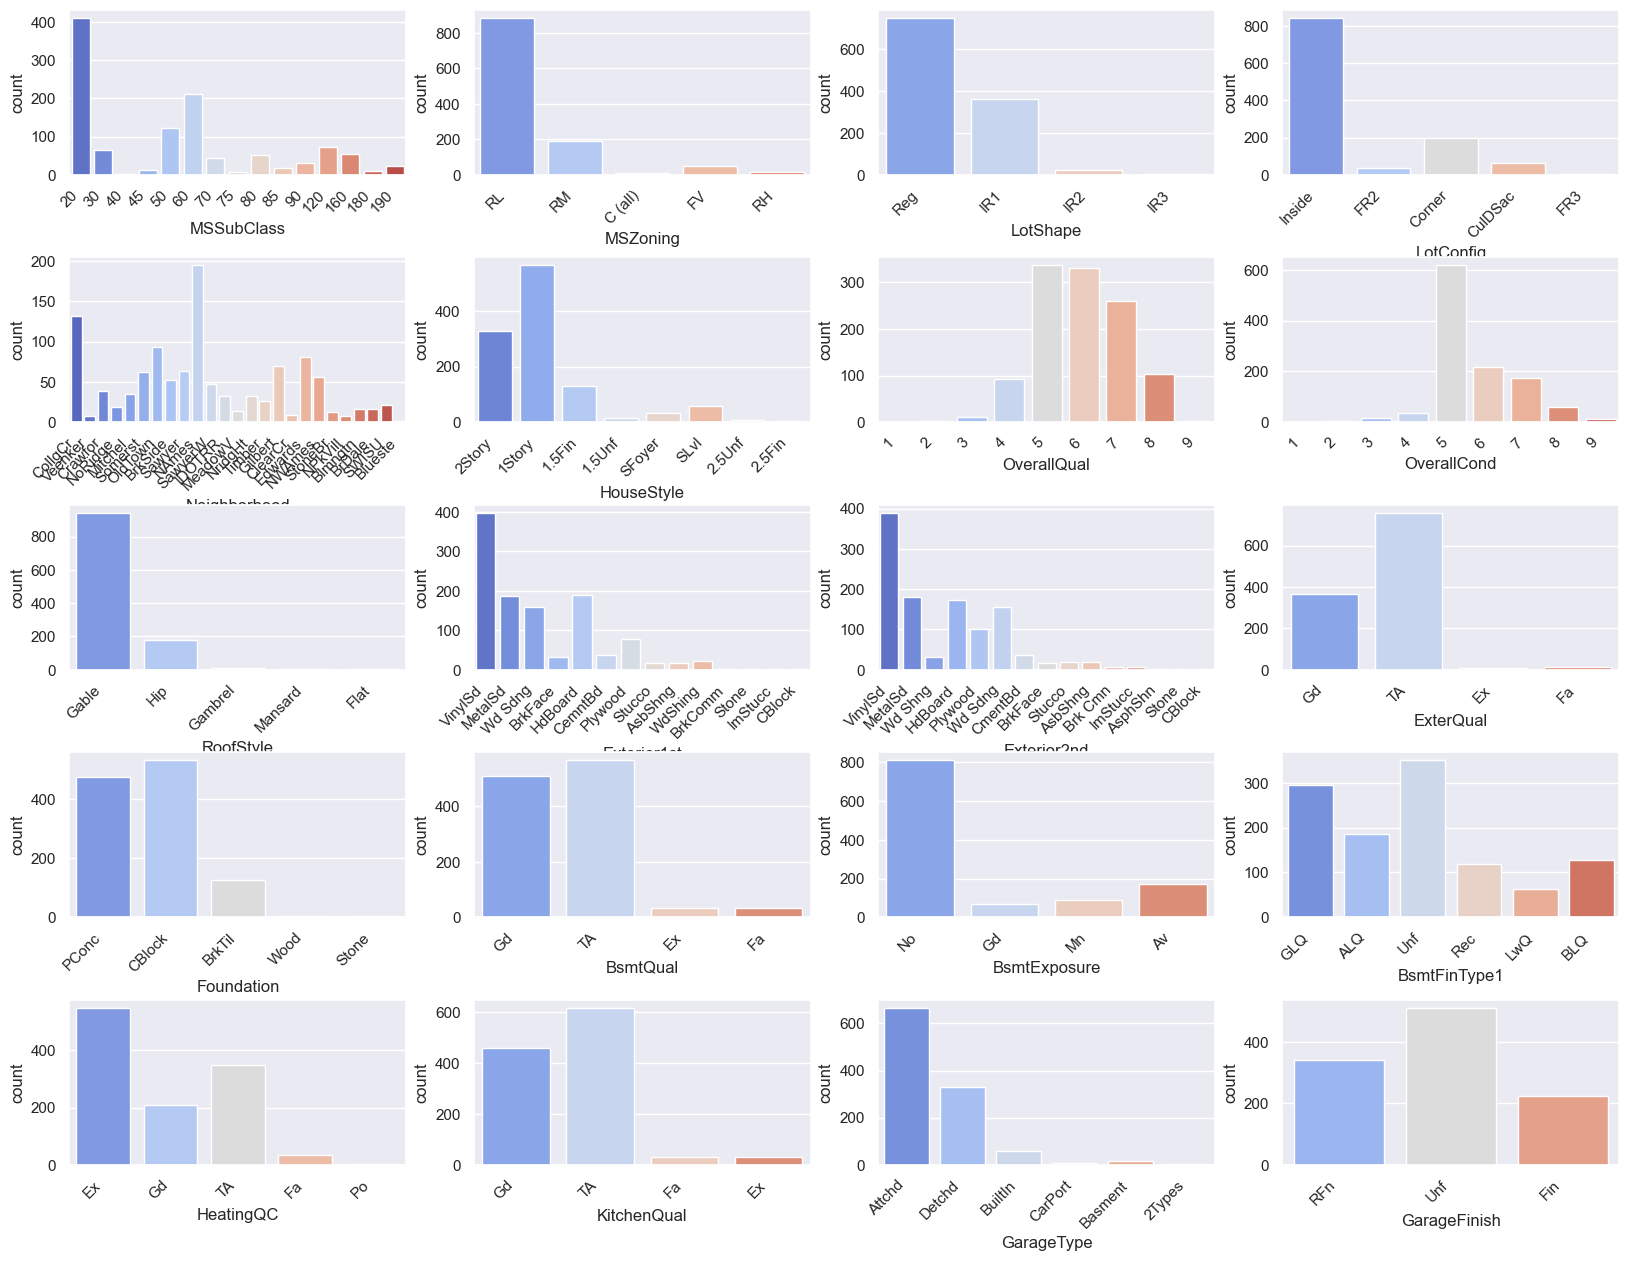

In [25]:
_cols = 4
_rows = int(np.ceil(len(cat_columns) / _cols))
fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(20, 15), gridspec_kw={'wspace':0.2,'hspace':0.5 })
ax = ax.flatten()

for idx, cat_col in enumerate(cat_columns):
    myplot=sns.countplot(df, x=cat_col, ax=ax[idx], palette ='coolwarm')
    myplot.set_xticklabels(myplot.get_xticklabels(), rotation=45,  horizontalalignment='right')

Распределение значений для признаков с порядковыми и интервальными  числовыми данными

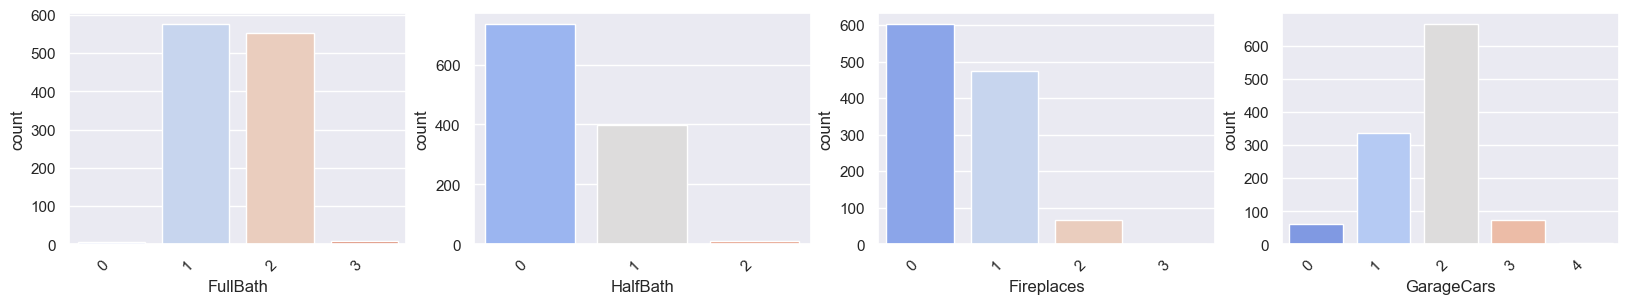

In [26]:
ord_columns_names =[col for col in df.columns if col in ORD_FEATURES and col in num_columns]
ord_columns=df[ord_columns_names].columns

_cols = 4
_rows = int(np.ceil(len(ord_columns) / _cols))
fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(20,3), gridspec_kw={'wspace':0.2,'hspace':0.3 })
ax = ax.flatten()

for idx, cat_col in enumerate(ord_columns):
    myplot=sns.countplot(df, x=cat_col, ax=ax[idx], palette ='coolwarm')
    myplot.set_xticklabels(myplot.get_xticklabels(), rotation=45,  horizontalalignment='right')

Оценим волатильность порядковых признаков относительно целевого признака

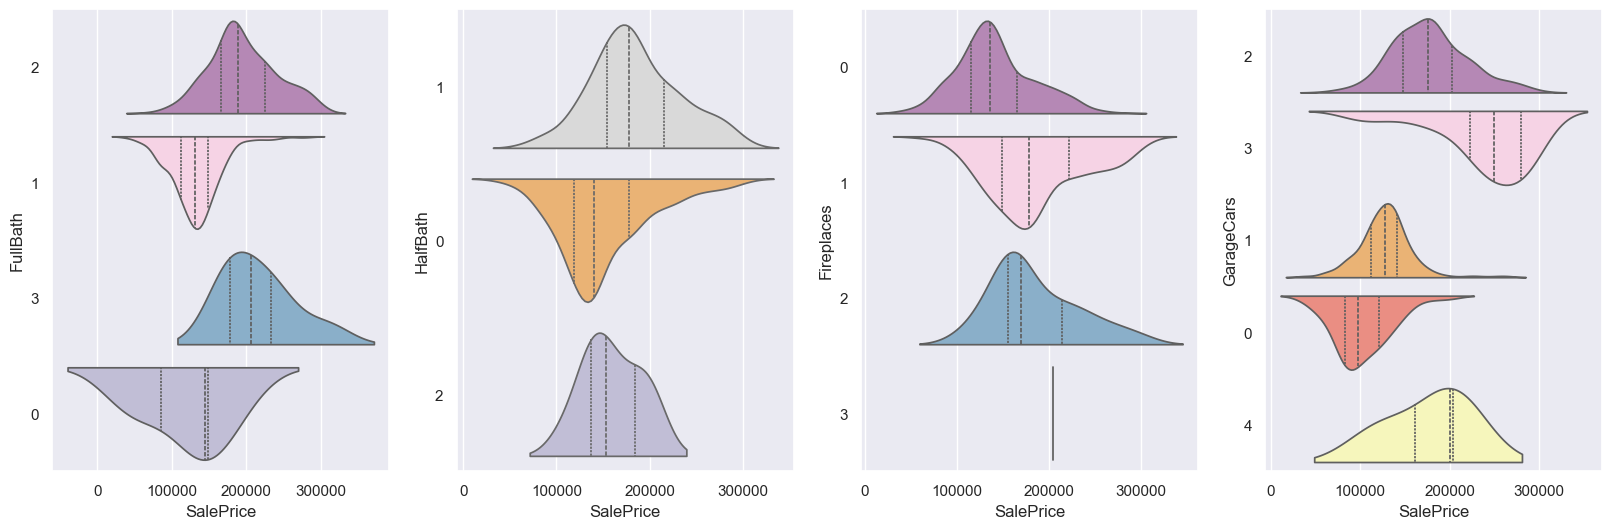

In [27]:
_cols = 4
_rows = int(np.ceil(len(ord_columns) / _cols))
fig, ax = plt.subplots(nrows=_rows, ncols=_cols, figsize=(20,6))
ax = ax.flatten()

for idx, cat_col in enumerate(ord_columns):
    sns.violinplot(
        df,
        x=df[TARGET_FEATURE],
        y=df[cat_col].astype(str),
        ax=ax[idx],
        orient='h',
        split=True,
        inner = "quartile",
        palette="Set3_r"
    )

Все категориальные и порядковые признаки распределены неравномерно относительно разных ценовых категорий. Наблюдается
дефицит значений для очень низкой и очень высокой цены.

# 5. Регрессия методом к-Ближайших Соседей

## 5.1. Подготовка разных датасетов

Логарифмирование приблизило распределение к нормальному, но неизвестно, как исчезновение преобладающего значения
повлияет на качество прогноза. Поэтому создадим дополнительные датасеты с логарифмированными данными, чтобы выяснить
это.

In [29]:
#Сохраним датасет с нелогарифмированными признаками
df_source=df.copy()

#Обычное логарифмирование
columns_to_log=['MasVnrArea','2ndFlrSF', 'OpenPorchSF']
df_log=df.copy()
df_log[columns_to_log]=np.log2(df[columns_to_log])
df_log.replace(to_replace=[ float('-inf')], value=0, inplace=True)

# С использованием трансформера sklearn.preprocessing.PowerTransformer
df_trans=df.copy()
PowerTransform = prep.PowerTransformer(standardize=False).fit(df_trans[columns_to_log])
df_trans[columns_to_log] = PowerTransform.transform(df_trans[columns_to_log])

Применяем KNeighborsRegressor.

## 5.2. Создание пайплайна

In [34]:
#Для числовых признаков
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ('NCA', NeighborhoodComponentsAnalysis(n_components=8))
])

# Для категориальных признаков
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse=False))
])

column_pipeline = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_columns),
    ("cat", cat_pipeline, cat_columns)
])

# Создаем модель-объект
model_pipeline = Pipeline([
    ("preprocessing", column_pipeline),
    ("model", KNeighborsRegressor(n_neighbors=13, weights="distance"))
])

Прогнозирование на данных без логарифмирования

In [35]:
#Текущий датасет:
df = df_source

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(TARGET_FEATURE, axis=1),
    df[TARGET_FEATURE],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# Обучаем
model_pipeline.fit(X_train, y_train)
# Метрики
regression_metrics(model_pipeline, X_test, y_test)

r2_score:  0.7688624250848402
rmse:  25205.482036028992
mae:  18978.416041905628


Прогнозирование на данных с обычным логарифмированием

In [36]:
#Текущий датасет:
df = df_log

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(TARGET_FEATURE, axis=1),
    df[TARGET_FEATURE],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# Обучаем
model_pipeline.fit(X_train, y_train)
# Метрики
regression_metrics(model_pipeline, X_test, y_test)

r2_score:  0.7211856531902145
rmse:  27683.263712874446
mae:  19811.48297726965


Прогнозирование на данных, обработанных с использованием трансформера sklearn.preprocessing.PowerTransformer

In [37]:
#Текущий датасет:
df = df_trans

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(TARGET_FEATURE, axis=1),
    df[TARGET_FEATURE],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# Обучаем
model_pipeline.fit(X_train, y_train)
# Метрики
regression_metrics(model_pipeline, X_test, y_test)

r2_score:  0.7611069568757234
rmse:  25624.858894193036
mae:  19089.35585249132


Таким образом, лучше всего работает датасет без логарифмирования. Попробуем оптимизировать гиперпараметры модели для
него.

In [38]:
df = df_source

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(TARGET_FEATURE, axis=1),
    df[TARGET_FEATURE],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

## 5.2. Оптимизация гиперпараметров с помощью поиска по сетке
Будем оптмизировать 3 гиперпараметра:
model__n_neighbors - число соседей;
preprocessing__num__NCA__n_components - размерность нового пространства;
model__weights -весовая функция, используемая в прогнозировании, возможны 2 значения.
Диапазоны значений для первых двух параметров подбирались эмпирическим путем.

In [39]:
param_grid = {
    "preprocessing__num__NCA__n_components": np.arange(6, 14, 1),
    "model__n_neighbors": np.arange(8, 16, 1),
    "model__weights": ["uniform", "distance"]
}
pipe_grid = GridSearchCV(estimator=model_pipeline,
                       param_grid=param_grid,
                       cv=KFold(n_splits=6))

In [40]:
pipe_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=6, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('NCA',
                                                                                          NeighborhoodComponentsAnalysis(n_components=8))]),
                                                                         Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd...
       'Exterior2nd', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'GarageType',
       'GarageFinish'],
      dtype='object'))])),
                                       ('model',
                                        KNeighborsRegressor(n_neighbors=13,
                                                            weights='distance'))]),
             param_grid={'model__n_neighbors': array([ 8,  9, 10, 11, 12, 13, 14, 15]),
                         'model__weights': ['uniform', 'distance'],
                         'preprocessing__num__NCA__n_components': array([ 6,  7,  8,  9, 10, 11, 12, 13])})

Найденный наилучший кандидат

In [41]:
best_estimator = pipe_grid.best_estimator_
regression_metrics(best_estimator, X_test, y_test)

r2_score:  0.757480309505661
rmse:  25818.632382486478
mae:  19280.10864343058


Результат получился даже хуже.

**Найденные гиперпараметры**

In [42]:
best_estimator.get_params()["model"]

KNeighborsRegressor(n_neighbors=14, weights='distance')

In [43]:
best_estimator.get_params()["preprocessing__num__NCA"]

NeighborhoodComponentsAnalysis(n_components=11)

## 5.3. Визуализация предсказаний модели и реальных значений

In [46]:
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

<Figure size 2000x500 with 0 Axes>

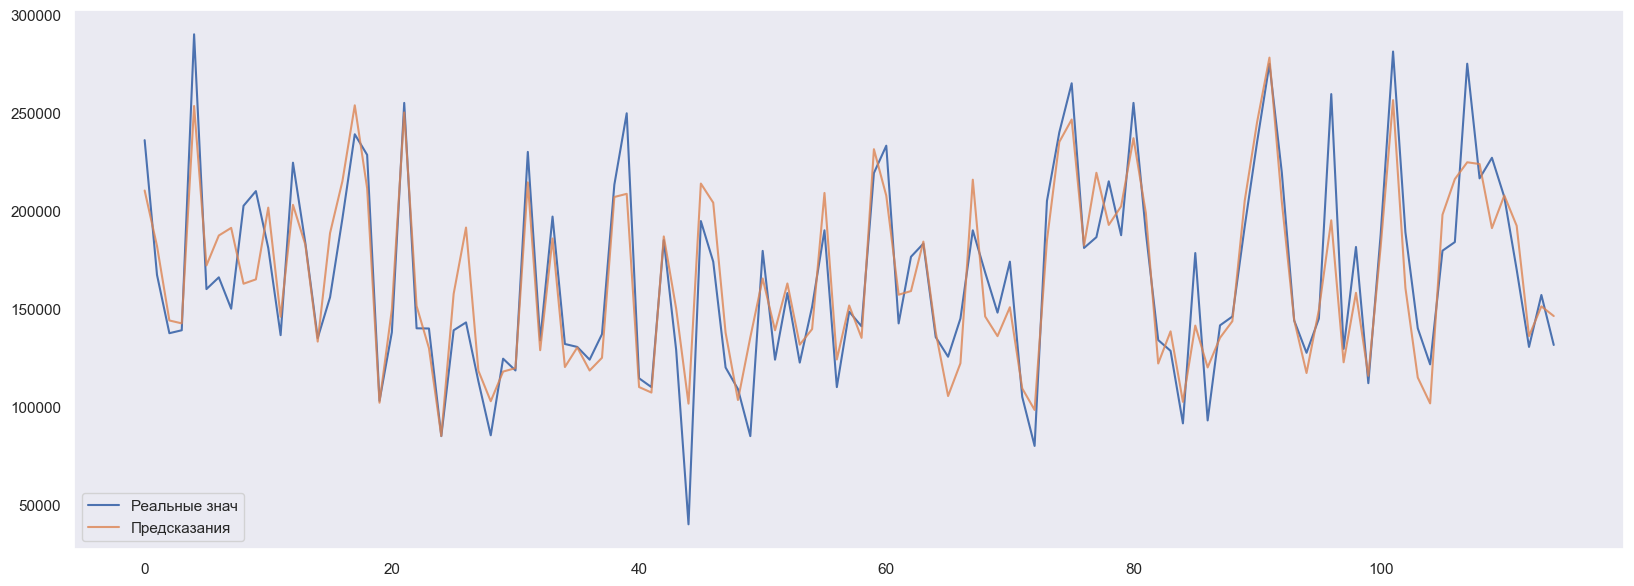

In [47]:
plt.suptitle("Предсказания и реальные значения")
plt.figure(figsize=(20, 7))
sns.lineplot(y_test.values[::3], label="Реальные знач")
sns.lineplot(y_pred[::3], label="Предсказания", alpha=0.8)
plt.legend()
plt.grid()

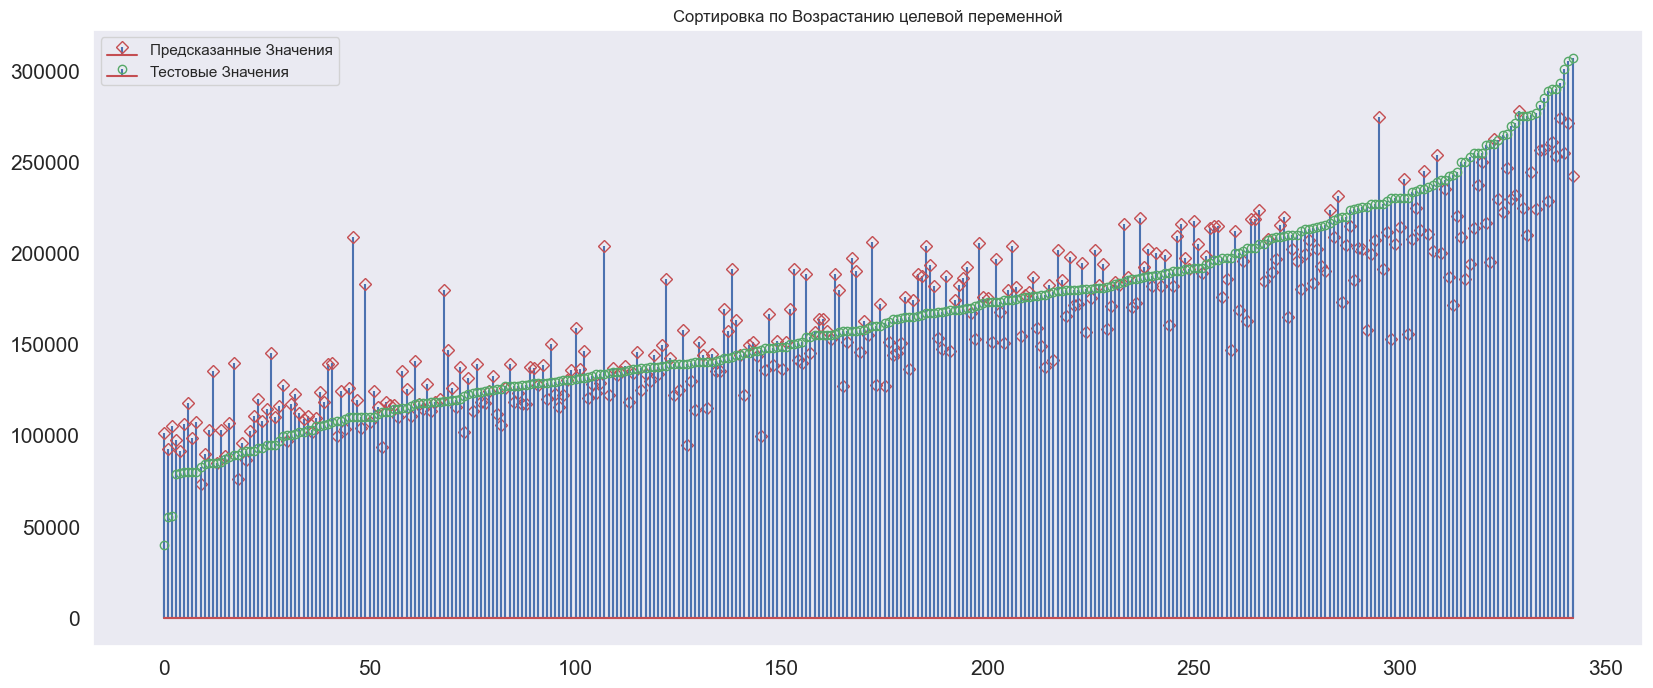

In [48]:
fig=plt.figure(figsize=(20, 8))
y_test1=y_test.values
sorted_y_test = np.argsort(y_test1)
print_stem(y_pred[sorted_y_test], 'Предсказанные Значения', 'rD')
print_stem(y_test1[sorted_y_test], 'Тестовые Значения', 'go')

plt.grid()
plt.title('Сортировка по Возрастанию целевой переменной')
plt.legend();
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

# 6. Выводы
1. Модель неплохо справилась с предсказанием. Возможно и лучше, за счет более тщательной работы с признаками(выбросами, пропусками).
2. Варьирование разного набора категориальных признаков, включенного в результируюший датасет, заметно влияет на качество модели.
3. Модель больше ошибается на пиковых значениях, т.е. локальных минимумах и максимумах.
4. Влияние NCA не выявлено.